# Explanation

Note, this doesn't actually exercise the robust confidence sequence of [Mineiro](2210.11133) because quantile elicitation functions are bounded, but it is here to facilitate understanding of the off-policy techniques.

For a real-valued discrete-time random process $X_t$, the code below constructs a confidence sequence for the CDF of the average historical conditional distribution, $$
\begin{aligned}
\overline{\text{CDF}}_t(v) &\doteq \frac{1}{t} \sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq v}\right],
\end{aligned}
$$
which is simultaneously valid for all times and all values.  It has guaranteed coverage properties, but not guaranteed width.  The inability to guarantee width under dependent data generation without additional assumptions is unavoidable, because threshold functions are [not sequentially uniformly convergent](https://arxiv.org/abs/1006.1138).  This is distinct from the iid setting, where threshold functions are [uniformly convergent with known rates](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality).  For further intuition consult the explicit construction in [Block et. al (2022)](https://arxiv.org/abs/2202.04690) appendix C.5 proposition 4.

[Smoothed distributions](https://arxiv.org/abs/2202.04690) are a tractable class of dependent data scenarios, and the core technique below provides a guaranteed width when the conditional distributions are smooth with respect to the uniform distribution on the unit interval, without requiring knowledge of the smoothness parameter.  This can be extended to a smoothness guarantee against a general reference measure by transformation via the inverse cdf of the reference measure.  For general reference measures with unbounded support but finite mean and variance, a standard Cauchy distribution provides a smoothness guarantee due to [Chebyshev's inequality](https://en.wikipedia.org/wiki/Chebyshev%27s_inequality).

Computationally the procedure is efficient: the technique requires amortized $O(\log(T))$ compute per data point to ingest $T$ data points, and $O(\log(T))$ compute to calculate the bound for a single value; furthermore the empirical CDF is a sufficient statistic (which is $O(T)$ space).

# Derivation

## Step 1: Test supermartingale for $Y_t \in \{0, 1\}$.

Note this is just the Binomial construction from [Howard et. al.](https://arxiv.org/abs/1810.08240).

$Y_t \in \{ 0, 1 \}$.  Individual means $\theta_t \doteq \mathbb{E}_{t-1}\left[Y_t\right]$, running mean $t \mu_t \doteq \sum_{s \leq t} \theta_s$, and running empirical mean $t \hat{\mu}_t \doteq \sum_{s \leq t} Y_s$.  The following is a martingale by construction $$
\begin{aligned}
E_t(\lambda) &= \exp\left(\lambda t \left(\hat{\mu}_t -\mu_t\right) - \sum_{s \leq t} \log\left(h(\lambda, \theta_s)\right) \right)  & \left( h(\lambda, z) \doteq (1 - z) e^{-\lambda z} + z e^{\lambda (1 - z)} \right) \\
\mathbb{E}_{t-1}\left[E_t(\lambda)\right] &= E_{t-1}(\lambda)  \mathbb{E}_{t-1}\left[\exp\left(\lambda \left(-\theta_t + Y_t\right) - \log\left(h(\lambda, \theta_t)\right)\right)\right] = E_{t-1}(\lambda),
\end{aligned}
$$ and is bounded below by $$
\begin{aligned}
E_t(\lambda) &\geq \exp\left(\lambda t \left(\hat{\mu}_t -\mu_t\right) - t \log\left(h(\lambda, \mu_t)\right) \right) & \left(\dagger\right) \\
&\doteq \left(\frac{p}{\mu_t}\right)^{t \hat{\mu}_t} \left(\frac{1 - p}{1 - \mu_t}\right)^{t (1 - \hat{\mu}_t)}, & \left(p \doteq \frac{\mu_t e^\lambda}{1 + (e^\lambda - 1) \mu_t}\right)
\end{aligned}
$$ 
where $(\dagger)$ follows from $\left( t f(q) = \max_{\theta \bigl| 1^\top \theta=t q} \sum_{s \leq t} f(\theta_s) \right)$ for any concave $f$.  


**Analytical Mixture**: Let $$
\begin{aligned}
W_t(b; \hat{\mu}_t, \mu_t) &= \frac{\int_{\mu_t}^1 d\text{Beta}\left(p; b \mu_t, b (1 - \mu_t)\right)\ \left(\frac{p}{\mu_t}\right)^{t \hat{\mu}_t} \left(\frac{1 - p}{1 - \mu_t}\right)^{t (1 - \hat{\mu}_t)}}{\int_{\mu_t}^1 d\text{Beta}\left(p; b \mu_t, b (1 - \mu_t)\right)} \\
&= \frac{1}{(1 - \mu_t)^{t (1 - \hat{\mu}_t)} \mu_t^{t \hat{\mu}_t}} \left(\frac{\text{Beta}(\mu_t, 1, b \mu_t + t \hat{\mu}_t, b (1 - \mu_t) + t (1 - \hat{\mu}_t))}{\text{Beta}(\mu_t, 1, b \mu_t, b (1 - \mu_t))}\right) \\
\end{aligned}
$$
where $\text{Beta}(a,1,c,d)$ is the [Mathematica version](https://reference.wolfram.com/language/ref/Beta.html).  Scipy provides [betainc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.betainc.html) and [betaln](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.betaln.html).  In case of numerical difficulties, we fall back to a Gaussian approximation.

## Step 2: Use a countably infinite collection of intervals

The $n$-th intervals models $\sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq u(n)}\right]$ via the test supermartingale.  Let $\alpha(n) \geq 0$ define a (decreasing) assignment of probability with $1 \geq \sum_{n=1}^\infty \alpha(n)$ for a union bound, e.g., $\alpha(n) = 6 / (\pi^2 n^2)$.

Although we have a countable infinite number of intervals covered with a union bound, there is no point in evaluating past the point where the bounds can improve.  Specifically, if all counts are to the left of the probe, there is no point in further refining the upper boundary.

# Code

In [1]:
class StreamingECDF(object):
    class FrozenECDF(object):
        def __init__(self, rawsd):
            from sortedcontainers import SortedDict
            super().__init__()
        
            self.sd = SortedDict()
            
            cumsum = 0
            for k, v in rawsd.items():
                cumsum += v
                self.sd[k] = cumsum
            
            self.tot = cumsum

        def __call__(self, H):
            if H is None:
                return self.tot
            
            hgeindex = self.sd.bisect_right(H)
            if hgeindex != len(self.sd):
                _, Hcnt = self.sd.peekitem(hgeindex)
            else:
                Hcnt = self.tot
                
            assert Hcnt <= self.tot, (Hcnt, H, self.tot)
            return Hcnt

    def __init__(self):
        from sortedcontainers import SortedDict
        super().__init__()
        
        self.sd = SortedDict()
        self.tot = 0
        
    def addobs(self, x):
        from numbers import Number
        assert isinstance(x, Number), x
        
        self.sd.setdefault(x, 0)
        self.sd[x] += 1
        self.tot += 1
        
    def freeze(self):
        return StreamingECDF.FrozenECDF(self.sd)

In [2]:
def getCSUpperBound(c, t, logp, b=1):
    from math import log
    from scipy.optimize import root_scalar
    
    assert t >= 1
    assert 0 <= c <= t
    muhat = c / t    
    thres = -logp

    def logwealth(mu):
        def logbetacdf(p, betaa, betab):
            from math import isfinite, log, log1p, sqrt
            from scipy.special import betainc, erf
            
            try:
                rv = log(betainc(betaa, betab, p))
                assert isfinite(rv)
            except:
                from scipy.stats import norm
                
                mean = betaa / (betaa + betab)
                var = betaa * betab / ((betaa + betab)**2 * (1 + betaa + betab))
                
                # The cumulative of the unit normal distribution is given by Phi(z) = 1/2[1 + erf(z/sqrt(2))].
                z = (p - mean) / sqrt(var)
                
                if z < -5 * sqrt(2):
                    from math import pi
                    rv = -z**2/2 - (1/2)*log(2*pi) - 5 * log(abs(z)) + log(3 - z**2 + z**4) # + O(log(1/z^7))
                else:
                    from math import erf
                    rv = -log(2) + log1p(erf(z/sqrt(2)))
                                
            assert isfinite(rv), (p, betaa, betab, rv)
            
            return rv
                
        from math import log1p, isfinite
        from scipy.special import betaln
        
        assert 0 < mu < 1
        
        numa, numb = b * mu + t * muhat, b * (1 - mu) + t * (1 - muhat)
        dena, denb = b * mu, b * (1 - mu)
        
        logsfnumerator = logbetacdf(p=mu, betaa=numa, betab=numb)
        logsfdenominator = logbetacdf(p=mu, betaa=dena, betab=denb)
        logbetanum = betaln(numa, numb)
        logbetaden = betaln(dena, denb)
        
        return -t * (1 - muhat) * log1p(-mu) - t * muhat * log(mu) + logbetanum + logsfnumerator - logbetaden - logsfdenominator
    
    mumin = max(muhat, 1/t)
    mumax = 1 - 1/t
    if mumin >= mumax or logwealth(mumax) <= thres:
        return 1
    
    if logwealth(mumin) >= thres:
        return mumin
    
    res = root_scalar(f=lambda mu: logwealth(mu) - thres, bracket=[mumin, mumax])
    assert res.converged
    return res.root

def getUnifUpperBound(probe, counts, conf):
    from math import log, ceil, pi
    
    ub0H = 1
    
    log6opsq = log(6/pi**2)
    logconf = log(conf)
    
    t = counts(None)
    cprobe = counts(probe)
    
    # technically depth range(1, infinity)
    # in practice we have finite numerical precision
    for depth in range(1, 100):
        # grid is (k / 2**depth) for k in [1, \ldots, 2**depth]
        # even values of k are duplicates from prior grids
        # hence size of grid not already covered is 2**(depth-1)
        
        logp = log6opsq - 2 * log(depth) - (depth - 1) * log(2)
        #                 ^--- union bound over depth
        #                                   ^--- shared by 2^(depth-1) 
        
        kupper = max(1, ceil(2**depth * probe))
        if kupper % 2 == 1:
            vupper = kupper / 2**depth
            cupper = counts(vupper) 
            ub0H = min(ub0H, getCSUpperBound(cupper, t, logp + logconf))
            if cupper <= cprobe:
                break
            
    return ub0H

def getGenericUpperBound(probe, counts, conf, *, refcdf, refppf):
    return getUnifUpperBound(refcdf(probe), lambda h: counts(None) if h is None else counts(refppf(h)), conf)

def getGenericLowerBound(probe, counts, conf, *, refsf, refisf):
    from math import inf
    return 1 - getUnifUpperBound(refsf(probe), lambda h: counts(None) if h is None else counts(None) - counts(refisf(h)), conf)

# Examples
In the examples below, a time-uniform version of [DKW](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality) is shown as a baseline just to get an idea of the empirical performance of the technique.  Note DKW does not hold for general data dependent generation.

In [3]:
def plotit(data, true, ref):
    from math import sqrt, log
    from scipy.interpolate import interp1d
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    
    T = len(data)    
    nxvals = 1000

    ecdfx = np.sort(data)
    ecdfy = np.arange(1, len(data)+1)/float(len(data))
    probevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=ecdfy, fp=ecdfx, left=0, right=1)
    ecdff = interp1d(x=ecdfx, y=ecdfy, fill_value=(0, 1), kind='previous', bounds_error=False)
    ecdffunc = np.array([ ecdff(v) for v in probevals ])

    exactcdfy = np.array([ true.cdf(x) for x in probevals ])
    
    plt.figure()
    plt.gcf().set_size_inches(16, 8)
    plt.plot(probevals, ecdffunc - exactcdfy, label='empirical minus exact cdf')
    
    counts = StreamingECDF()
    for x in data:
        counts.addobs(x)
        
    icey = counts.freeze()
    
    conf = 0.05
    
    from math import pi, log
    
    # tree
    lbcdfy = np.array([ getGenericLowerBound(x, icey, conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
    start = time.time()
    ubcdfy = np.array([ getGenericUpperBound(x, icey, conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
    end = time.time()

    plt.plot(probevals, ubcdfy - exactcdfy, label='cdf ub minus exact')
    plt.plot(probevals, exactcdfy - lbcdfy, label='cdf exact minus lb')
    plt.title('difference between bounds and exact CDF')
    plt.legend()
    #plt.savefig(f'fixedvaluequantiletreedelta.beta({betaa},{betab}).png', bbox_inches='tight')
    
    # DKW
    logtuconf = log(conf) + log(6/pi**2) - 2*log(T)
    dkwtueps = sqrt((log(2) - logtuconf) / (2 * T))
    plt.figure()
    plt.gcf().set_size_inches(16, 8)
    plt.plot(probevals, ubcdfy - lbcdfy, label='bound width')
    plt.plot(probevals, [2*dkwtueps]*len(probevals), label=f'dkw t-unif width ({2*dkwtueps:.3g})', linestyle='dashed')
    plt.title(f'bound widths for T={T} draws from {true.desc}')
    plt.legend()

    plt.figure()
    plt.gcf().set_size_inches(16, 8)
    plt.plot(probevals, ecdffunc, label='empirical cdf')
    plt.plot(probevals, lbcdfy, label='cdf lb')
    plt.plot(probevals, ubcdfy, label='cdf ub')
    plt.title(f'ubcdf calc time for T={T} at {nxvals} evenly spaced x-values: {end-start:.3f} s')
    #plt.savefig(f'fixedvaluequantiletreecdf.beta({betaa},{betab}).png', bbox_inches='tight')
    plt.legend()

### Beta(5,3) distribution
Using the uniform$([0,1])$ distribution as reference measure.

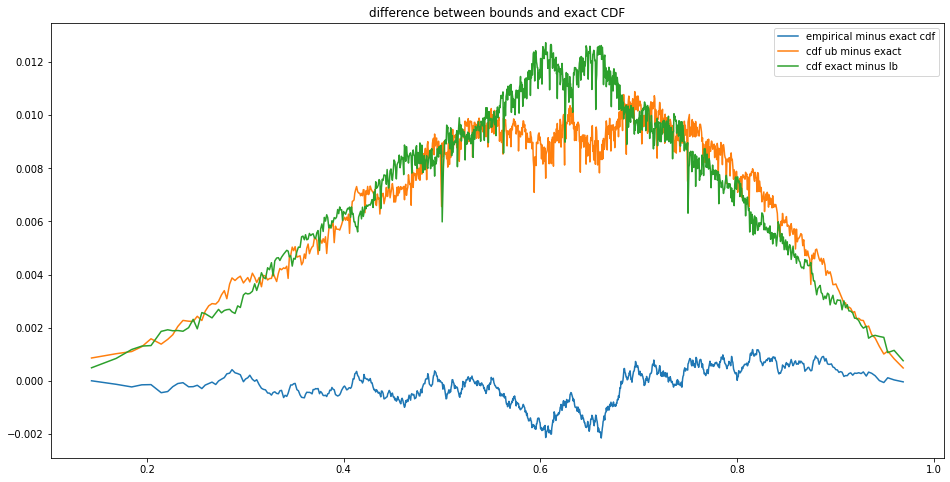

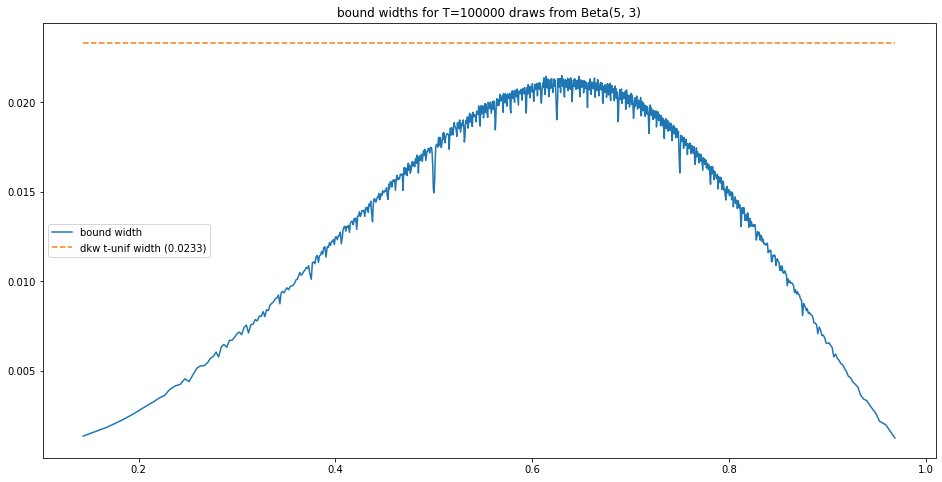

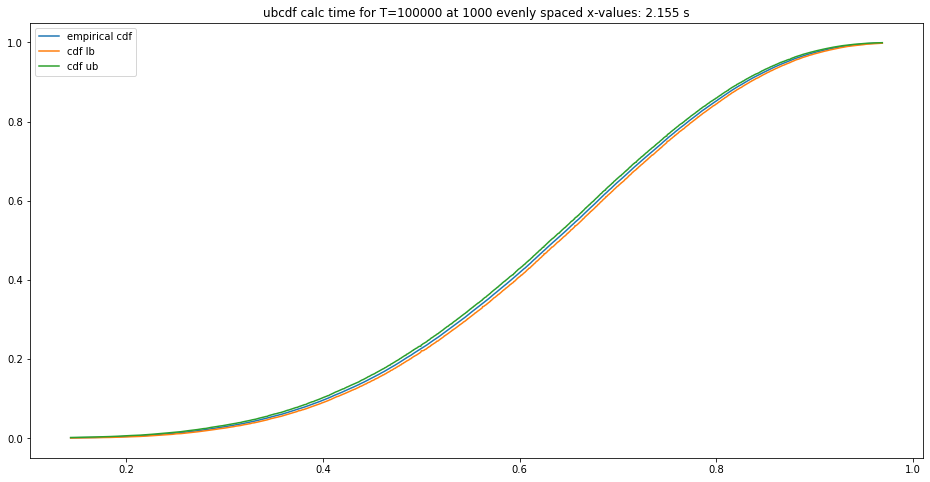

In [4]:
def flass(seed=4546):
    from scipy.special import betainc
    from numpy.random import default_rng

    betaa, betab = 5, 3
    T = 100000
    
    rng = default_rng(seed)
    data = rng.beta(betaa, betab, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'Beta({betaa}, {betab})',
                cdf = lambda slf, x: betainc(betaa, betab, x)
               )
    
    # scipy is stupid slow for some reason
    # from scipy.stats import uniform
    # ref = uniform()
    
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
    
    plotit(data, true, ref)

flass()

### Beta(5,30000) distribution (supported on $[0,1]$)
Less smooth with respect to the uniform$([0,1])$ distribution, so the bounds are degraded.

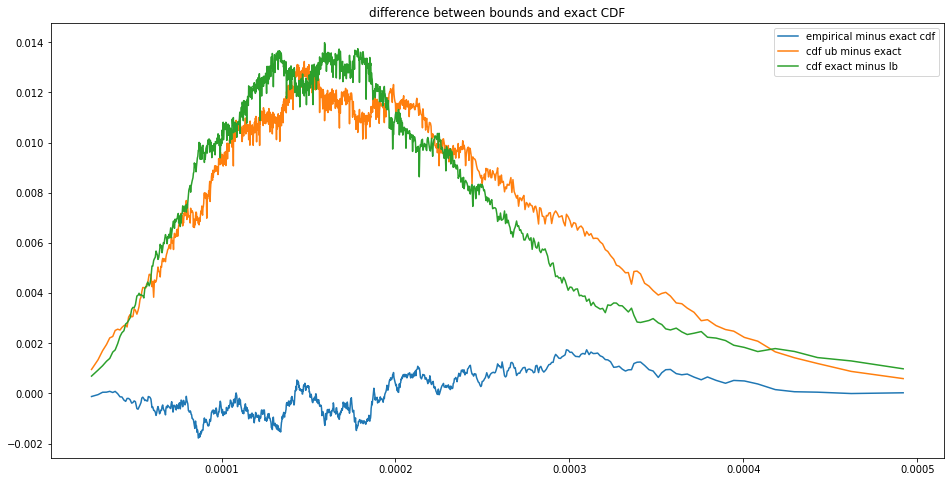

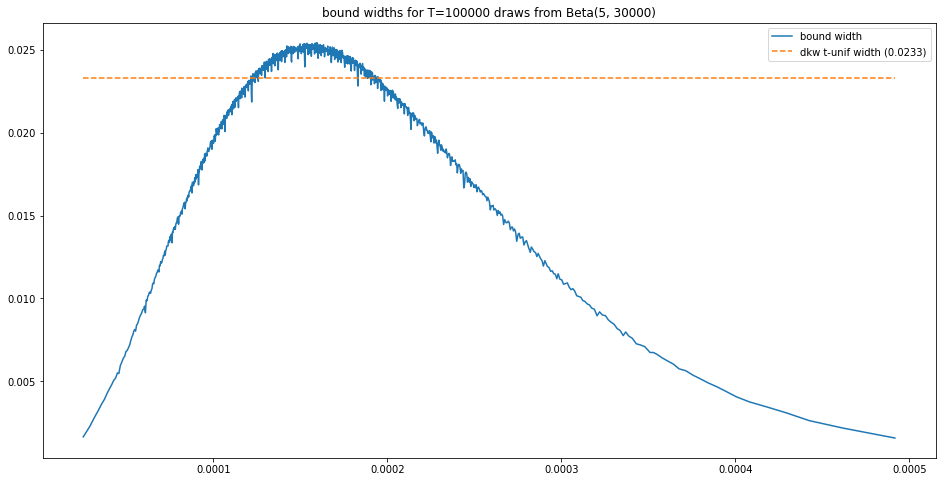

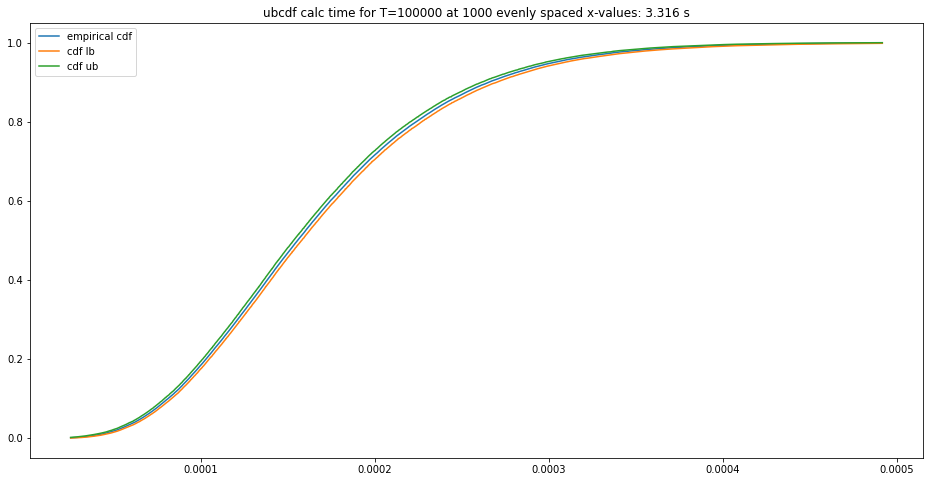

In [5]:
def flass(seed=4546):
    from scipy.special import betainc
    from numpy.random import default_rng

    betaa, betab = 5, 30000
    T = 100000
    
    rng = default_rng(seed)
    data = rng.beta(betaa, betab, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'Beta({betaa}, {betab})',
                cdf = lambda slf, x: betainc(betaa, betab, x)
               )
    
    # scipy is stupid slow for some reason
    # from scipy.stats import uniform
    # ref = uniform()
    
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
    
    plotit(data, true, ref)

flass()

### Soft Polya Urn
$$
\begin{aligned}
X_t &\sim \text{Beta}\left(1 + \gamma \sum_{s < t} 1_{X_s > 1/2}, 1 + \gamma \sum_{s < t} 1_{X_s < 1/2} \right)
\end{aligned}
$$
Note slowness is due to simulation and calculation of the exact CDF, not due to bounds calculation.  We're using the uniform$([0,1])$ distribution as reference measure, but this gets increasingly less smooth as $T$ increases.

3.200000000000002 998.7000000001585


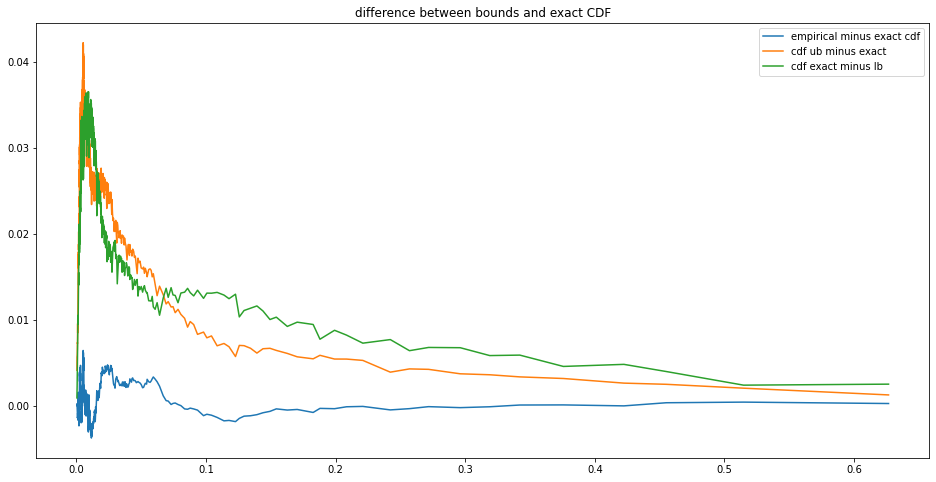

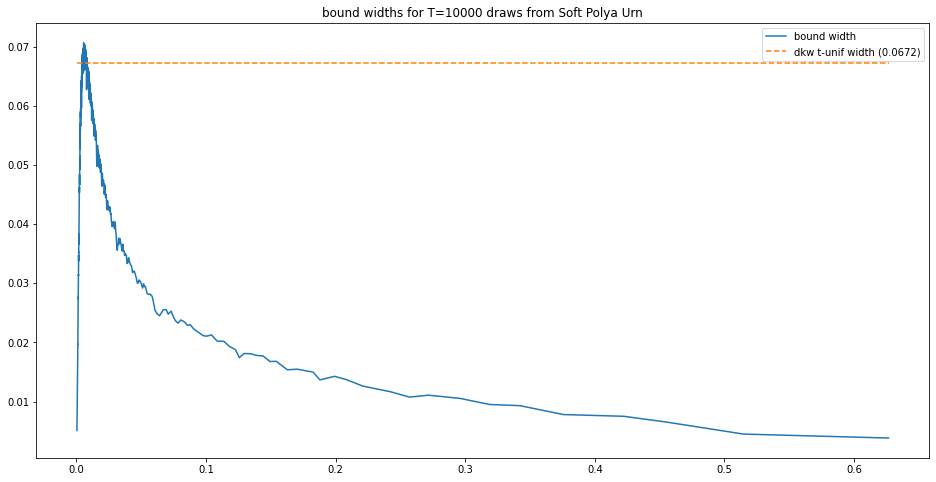

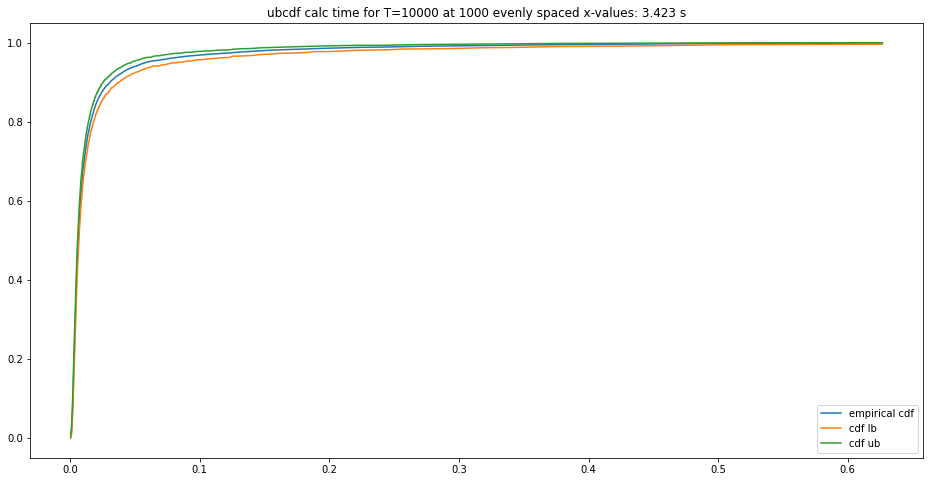

In [6]:
def flass(seed=4546):
    from scipy.special import betainc
    import numpy as np
    from numpy.random import default_rng

    T = 10000
    
    rng = default_rng(seed)
    
    data = []
    betaa = [1]
    betab = [1]
    gamma = 1/10
    for n in range(T):
        data.append(rng.beta(betaa[-1], betab[-1]))
        betaa.append(betaa[-1])
        betab.append(betab[-1])
        if 2 * data[-1] < 1:
            betab[-1] += gamma
        elif 2 * data[-1] > 1:
            betaa[-1] += gamma
    
    betaa.pop()
    betab.pop()
    print(f'{betaa[-1]} {betab[-1]}')
    data = np.array(data)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'Soft Polya Urn',
                cdf = lambda slf, x: sum(betainc(a, b, x) for a, b in zip(betaa, betab))/T,
               )
    
    # scipy is stupid slow for some reason
    # from scipy.stats import uniform
    # ref = uniform()
    
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
    
    plotit(data, true, ref)

# seed 4550 concentrates at 0
# seed 4548 concentrates at 1
flass(4550)

### Lognormal Distribution (supported on $[0, \infty)$)
Using a standard Cauchy as the reference measure.

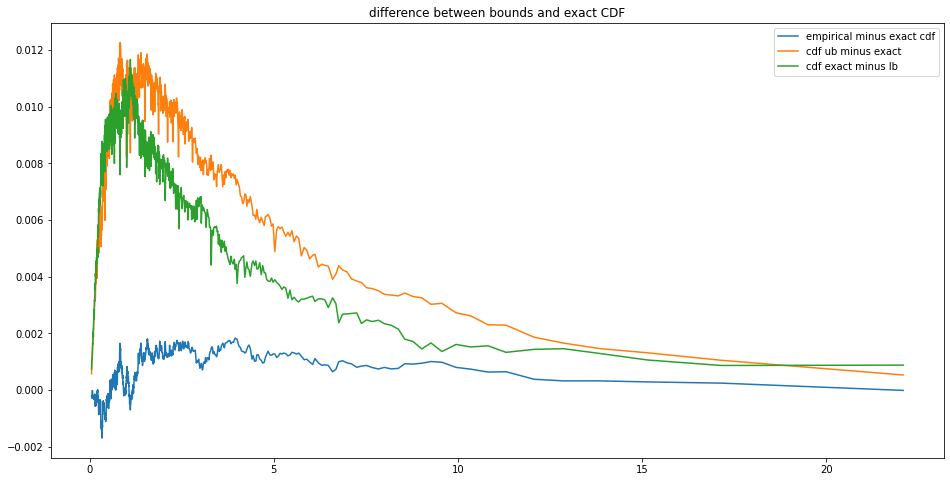

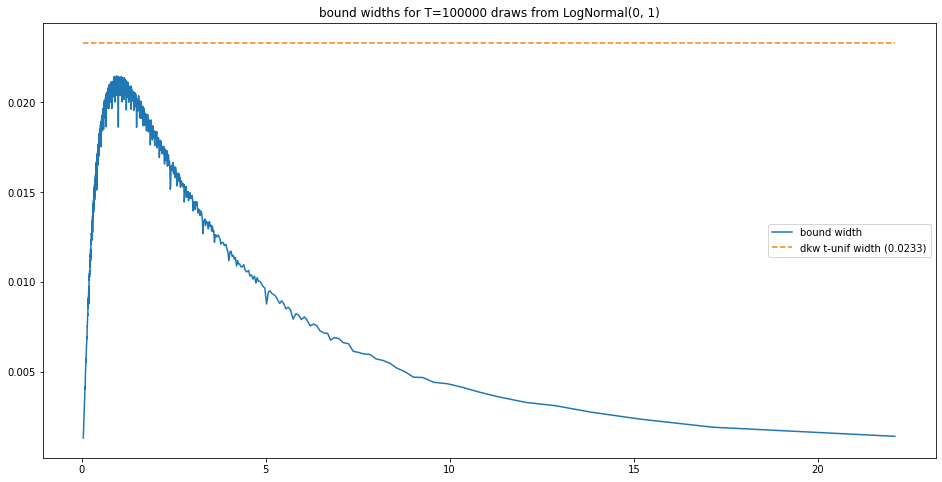

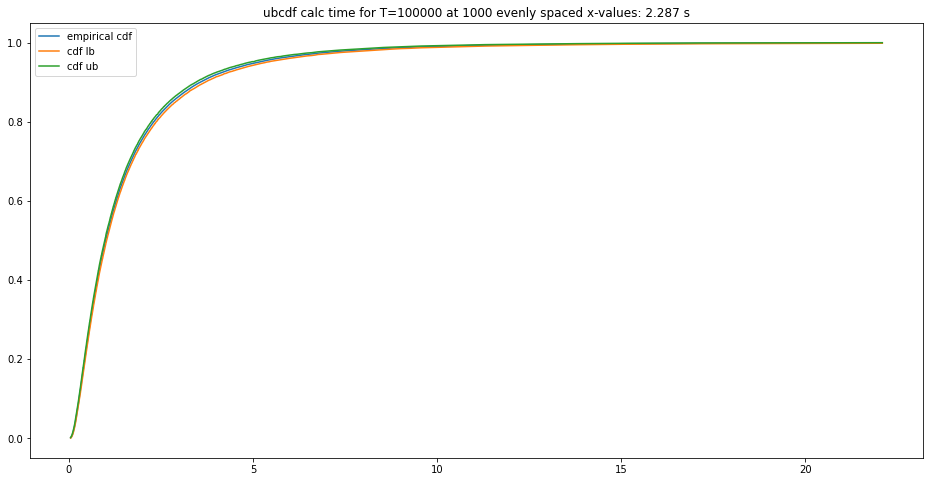

In [7]:
def flass(seed=4546):
    from math import exp, erfc, log, sqrt, atan, pi, tan
    # scipy is stupid slow for some reason
    #from scipy.stats import cauchy, lognorm
    from scipy.special import betainc
    from numpy.random import default_rng

    mu, sigma = 0, 1
    T = 100000
    
    rng = default_rng(seed)
    data = rng.lognormal(mu, sigma, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'LogNormal({mu}, {sigma})',
                cdf = lambda slf, x: 0 if x <= 0 else 1/2 * erfc((mu - log(x))/(sqrt(2)*sigma)),
               )
    
    #ref = cauchy()
    ref = Anon(cdf = lambda slf, x: 1/2 + atan(x)/pi,
               ppf = lambda slf, x: tan(pi*(x - 1/2)),
               sf = lambda slf, x: 1/2 - atan(x)/pi,
               isf = lambda slf, x: -tan(pi*(x - 1/2)),
              )
    
    plotit(data, true, ref)

flass()

### Gaussian Distribution (supported on $(-\infty, \infty)$)
Using a standard Cauchy as the reference measure.

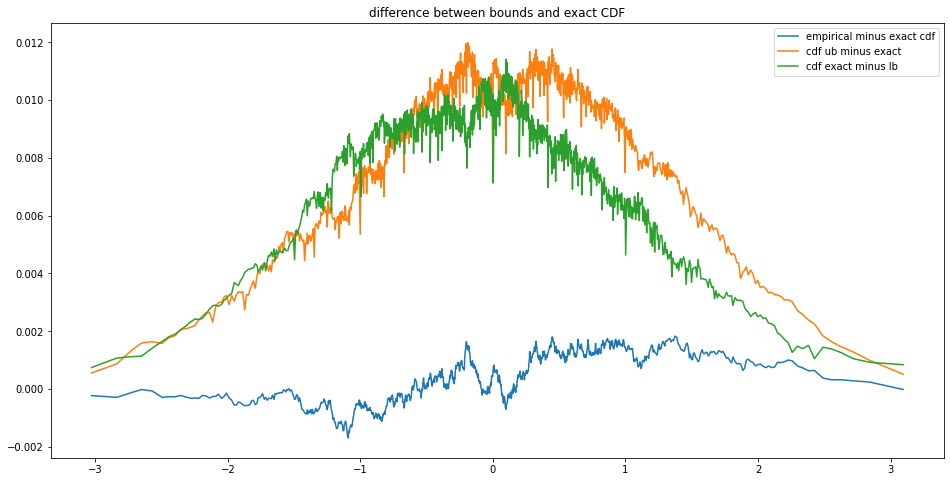

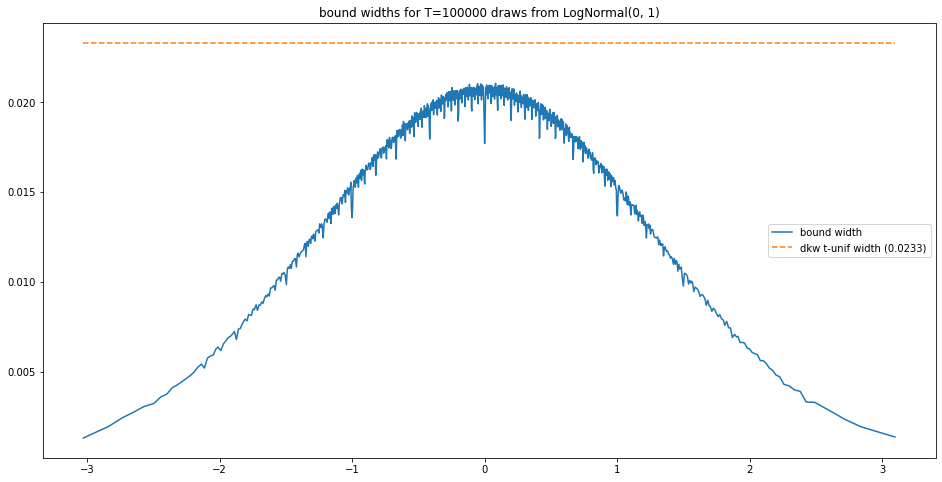

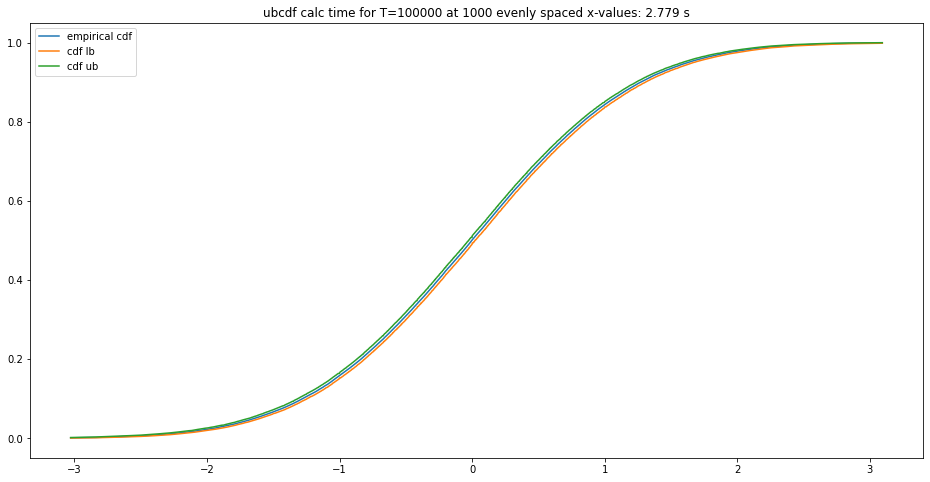

In [8]:
def flass(seed=4546):
    from math import exp, erfc, log, sqrt, atan, pi, tan
    # scipy is stupid slow for some reason
    #from scipy.stats import cauchy, norm
    from scipy.special import betainc
    from numpy.random import default_rng

    mu, sigma = 0, 1
    T = 100000
    
    rng = default_rng(seed)
    data = rng.normal(mu, sigma, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'LogNormal({mu}, {sigma})',
                cdf = lambda slf, x: 1/2 * erfc((mu - x)/(sqrt(2)*sigma)),
               )
    
    #ref = cauchy()
    ref = Anon(cdf = lambda slf, x: 1/2 + atan(x)/pi,
               ppf = lambda slf, x: tan(pi*(x - 1/2)),
               sf = lambda slf, x: 1/2 - atan(x)/pi,
               isf = lambda slf, x: -tan(pi*(x - 1/2)),
              )
    
    plotit(data, true, ref)

flass()